Vision Transformers (ViT)

Necessary imports and model definition

In [32]:
import torch
from timm import create_model

# Initialize the DeiT model with pretrained weights
model = create_model('deit_small_patch16_224', pretrained=True, num_classes=2)
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

Loading and transforming the data

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import os

# Define the data transformations with added augmentations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop for data augmentation
    transforms.RandomHorizontalFlip(),  # Random flip for data augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.RandomRotation(10),  # Random rotation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for DeiT
])

# Load the dataset from the dataset folder containing both classes ("Normal" and "Stroke" subfolders)
dataset = ImageFolder(root='dataset', transform=transform)

# Define split sizes for training (80%) and testing (20%)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Perform the split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print class names and the number of samples in each set
print(f"Classes: {dataset.classes}")
print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Classes: ['Normal', 'Stroke']
Training samples: 3863, Test samples: 966


Loss, Optimizer and Learning Rate

In [34]:
import torch.optim as optim

# Define the optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Define a learning rate scheduler (CosineAnnealing or ReduceLROnPlateau)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

Data Mixup

In [35]:
import numpy as np

def mixup_data(x, y, alpha=0.4):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

Model Training

In [ ]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Initialize best validation loss to infinity
epochs_no_improve = 0  # Counter for non-improving epochs

num_epochs = 20
early_stop = False

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # Training loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Apply mixup
        mixed_images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=0.4)

        # Forward pass
        outputs = model(mixed_images)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Update scheduler
    scheduler.step()

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Calculate average validation loss
    val_loss /= len(test_loader)

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        epochs_no_improve += 1

    # Print training and validation stats
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping check
    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        early_stop = True
        break

if early_stop:
    # Load the best model before stopping
    model.load_state_dict(torch.load('best_model.pth'))


Epoch [1/20], Loss: 0.5381, Val Loss: 0.3870
Epoch [2/20], Loss: 0.5131, Val Loss: 0.3752
Epoch [3/20], Loss: 0.4691, Val Loss: 0.3456
Epoch [4/20], Loss: 0.4683, Val Loss: 0.3311
Epoch [5/20], Loss: 0.4094, Val Loss: 0.2830
Epoch [6/20], Loss: 0.4012, Val Loss: 0.2673
Epoch [7/20], Loss: 0.3741, Val Loss: 0.2353
Epoch [8/20], Loss: 0.3282, Val Loss: 0.1956
Epoch [9/20], Loss: 0.3408, Val Loss: 0.1944
Epoch [10/20], Loss: 0.3001, Val Loss: 0.1830
Epoch [11/20], Loss: 0.2952, Val Loss: 0.1840
Epoch [12/20], Loss: 0.3144, Val Loss: 0.1809
Epoch [13/20], Loss: 0.2933, Val Loss: 0.1685
Epoch [14/20], Loss: 0.3152, Val Loss: 0.1697
Epoch [15/20], Loss: 0.3202, Val Loss: 0.1751
Epoch [16/20], Loss: 0.3351, Val Loss: 0.1972
Early stopping triggered.


Model performance evaluation

Test Accuracy: 94.41%
Confusion Matrix:
[[548   7]
 [ 47 364]]


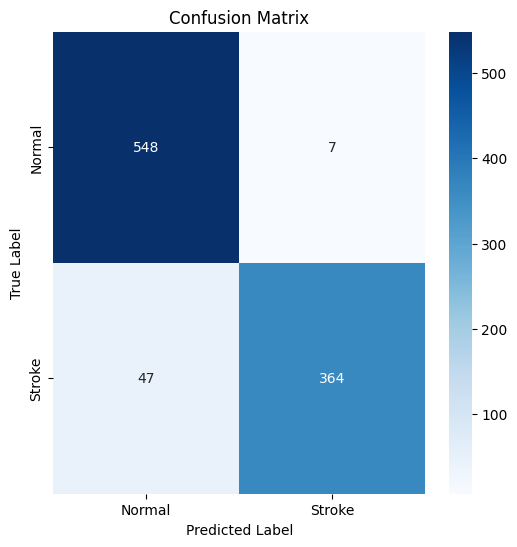

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# Switch model to evaluation mode
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Calculate and display confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
